In [47]:
import pandas as pd
import numpy as np
import os as os
import aux.acessos as ac
import aux.aed as aed
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

Query

In [29]:
query = """

with chats_agg as (
	select 
	dt_chat,
	count(distinct id_issue) as chats
	FROM cx_curated_zone.cx_contact_rate 
	where dt_chat >= to_date('2022-01-01','yyyy-mm-dd')
	group by 1
)
, base_eventos as (
	select f.id_customer
	    ,f.cpf
		,f.ds_event_name
		,f.nr_ocorr
		,f.dt_event
		,d.ds_subgrupo
		,d.ds_descricao  from 
		customer_curated_zone.ca_analitico_frontend f
		left join customer_curated_zone.ca_dict_frontend_events as d
		on f.ds_event_name = d.ds_event_name
)
, eventos_agg as (
	select
	dt_event
	, count(distinct case when nr_ocorr > 5 then cpf end) / cast(count(distinct cpf) as double)  as p_clientes_ocorr_mais5
	, count(distinct case when nr_ocorr > 10 then cpf end)/ cast(count(distinct cpf) as double) as p_clientes_ocorr_mais10
	, count(distinct case when nr_ocorr > 20 then cpf end)/ cast(count(distinct cpf) as double) as p_clientes_ocorr_mais20
	from base_eventos where dt_event >= to_date('2022-01-01','yyyy-mm-dd')
	group by 1
)
, erros_aut_agg as (
	select 
	dt_transacao 
	, sum(case when flag_erro = 1 then transacoes end) / cast(sum(transacoes)as double) as p_erros_transacoes
	from platform_analytics_zone.tx_autorizacao_pag_will_conceito_master
	where cast(dt_transacao as date) >= to_date('2022-01-01','yyyy-mm-dd')
	group by 1
)
, aumento_limite_agg as (
	select
	dt_alt_lim
	, count(distinct case when Limite_aprovado > limite_aprovado_antes then cpf end) clientes_com_aumento
	from credit_curated_zone.credit_alteracao_limite_will
	where cast(dt_alt_lim as date) >= to_date('2022-01-01','yyyy-mm-dd')
	group by 1
)
, cartao_agg as (
	select 
	dia
	, SUM(ativos_dia) as ativos_dia 
	, SUM(spending_dia) as spending_dia 
	from platform_analytics_zone.daily_spending_pag_will
	where cast(dia as date) >= to_date('2022-01-01','yyyy-mm-dd')
	group by 1
	order by 1
)
, transacional_cartao_dia as (
	select 
	t.dt_dia
	, t.cpf
	, c.ds_cluster_sociodemographic 
	, sum(vl_transacao) as vl_spending
	, count(distinct id_autorizacao) as transacoes
	from platform_curated_zone.transaction_dedicada_spending t
	left join customer_curated_zone.ca_book_cliente i on (i.cpf = t.cpf)
	left join customer_curated_zone.ca_book_cliente_cluster c on (c.id_customer = i.id_customer)
	where cast(dt_dia as date) >= to_date('2022-01-01','yyyy-mm-dd')
	group by 1,2,3
)
, limites as (
	select
	dt_dia 
	, ds_cluster_sociodemographic
	, approx_percentile(vl_spending, 0.98) as valor_limite_superior
	from transacional_cartao_dia
	group by 1,2
)
, fraude_agg as (
	select
	tc.dt_dia
	, count(distinct case when  vl_spending > valor_limite_superior then tc.cpf end) as clientes_gasto_acima_normal
	, sum(case when  vl_spending > valor_limite_superior then tc.vl_spending end) as valor_acima_normal
	from transacional_cartao_dia tc
	left join limites l on (l.dt_dia = tc.dt_dia and l.ds_cluster_sociodemographic = tc.ds_cluster_sociodemographic)
	group by 1
	order by 1
)
select
dt_chat
, chats
, p_clientes_ocorr_mais5
, p_clientes_ocorr_mais10
, p_erros_transacoes
, clientes_com_aumento / cast(ativos_dia as double) as p_clientes_com_aumento
, ativos_dia
, spending_dia
, valor_acima_normal
from chats_agg c
left join eventos_agg e on (c.dt_chat = e.dt_event)
left join erros_aut_agg aut on (c.dt_chat = cast(aut.dt_transacao as date))
left join aumento_limite_agg l on (c.dt_chat = l.dt_alt_lim)
left join cartao_agg ct on (c.dt_chat = cast(ct.dia as date))
left join fraude_agg f on (c.dt_chat = cast(f.dt_dia as date))
order by dt_chat asc

"""


In [98]:
df = ac.df_athena('flavia-costa', query)

In [31]:
df.head()

,dt_chat,chats,p_clientes_ocorr_mais5,p_clientes_ocorr_mais10,p_erros_transacoes,p_clientes_com_aumento,ativos_dia,spending_dia,valor_acima_normal
0,2022-01-01,3017,0.318634,0.234045,0.209983,NaN,82335,6973501,2625468.67
1,2022-01-02,4672,0.369727,0.290729,0.184259,NaN,105013,11115914,4897713.14
2,2022-01-03,11576,0.465657,0.351154,0.175143,NaN,132005,23459473,9988947.88
3,2022-01-04,14037,0.364380,0.243960,0.171539,NaN,147917,32215289,14161653.41
4,2022-01-05,12207,0.340251,0.219699,0.165217,NaN,150791,31674467,14820685.99


In [32]:
df.tail()

,dt_chat,chats,p_clientes_ocorr_mais5,p_clientes_ocorr_mais10,p_erros_transacoes,p_clientes_com_aumento,ativos_dia,spending_dia,valor_acima_normal
344,2022-12-11,9564,0.155718,0.065719,0.165902,NaN,218702,29804221,29312002.47
345,2022-12-12,22382,0.199203,0.089159,0.174552,NaN,266469,56185587,53444173.72
346,2022-12-13,21210,0.185061,0.081349,0.176174,0.067873,253046,49999237,46744875.19
347,2022-12-14,26502,NaN,NaN,0.165371,NaN,141818,23044299,51787504.44
348,2022-12-15,543,NaN,NaN,0.376882,NaN,1687,140050,233061.02


Text(0.5, 1.0, 'Percentual de cliente com aumento')

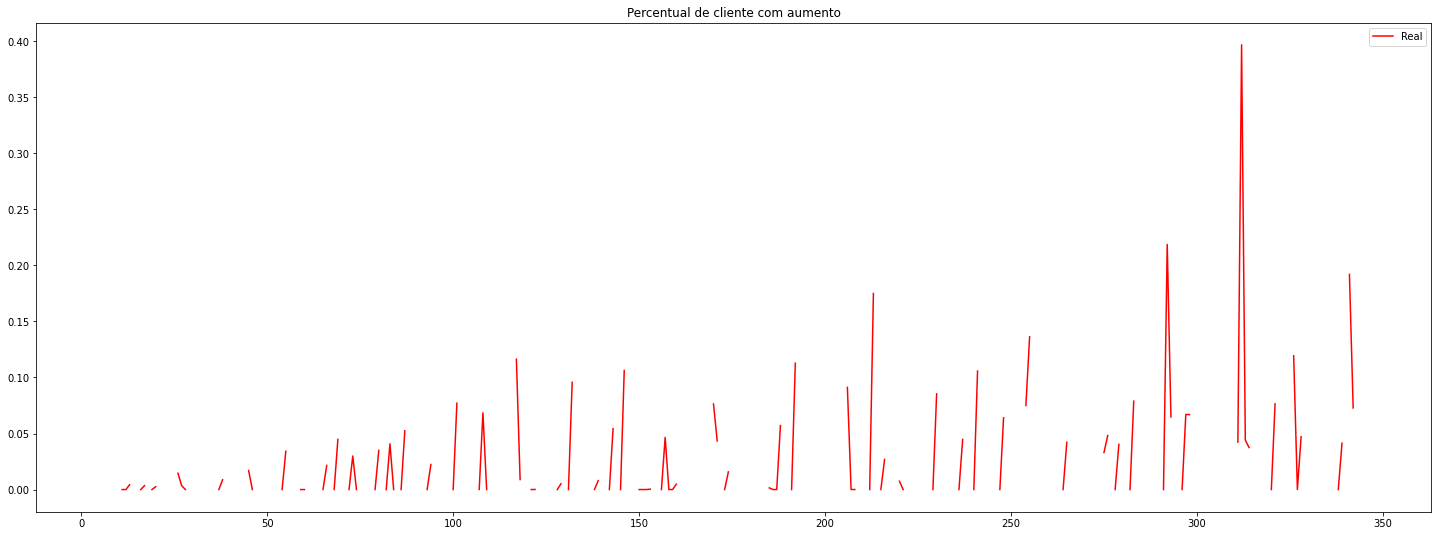

In [33]:
plt.figure(figsize=(25,9))
plt.plot(df['p_clientes_com_aumento'], color = 'red', label = 'Real')
plt.legend()
plt.title('Percentual de cliente com aumento')


In [73]:
df['p_clientes_com_aumento'].describe()

count    349.000000
mean       0.014602
std        0.037560
min        0.000000
25%        0.000000
50%        0.000000
75%        0.003486
max        0.396827
Name: p_clientes_com_aumento, dtype: float64

In [76]:
(df['p_clientes_com_aumento'] > 0.02).sum()

70

Análise exploratória

In [8]:
id_columns = ['dt_chat']

aed.valid(df, id_columns)

tamanho do dataset:
347
valores nulos:
dt_chat                      0
chats                        0
p_clientes_ocorr_mais5       1
p_clientes_ocorr_mais10      1
p_erros_transacoes           0
p_clientes_com_aumento     191
ativos_dia                   0
spending_dia                 0
valor_acima_normal           0
dtype: int64
valores distintos das variaveis categoricas:
____________________________
chats
mínimo:
506.0
máximo:
35068.0
media:
16870.057636887606
mediana:
17570.0
coeficiente de variação:
35.029349783736514
coeficiente de assimetria de pearson:
-0.35533246753552417
assimétrica negativa - concentração em valores maiores
quantidade de outliers:
0
quantidade de outliers percentual:
0.0
____________________________
p_clientes_ocorr_mais5
mínimo:
0.09241771762534605
máximo:
0.8013519933984046
media:
0.2552111557857466
mediana:
0.24133963908569536
coeficiente de variação:
33.05342997082332
coeficiente de assimetria de pearson:
0.49332033339694575
assimétrica positiva - concent

In [13]:
aed.find_correl(df, id_columns, 0.85)

p_clientes_ocorr_mais5 ---> p_clientes_ocorr_mais10 -> correlacao de 0.9715384732381024
__________________________________________
p_clientes_ocorr_mais10 ---> p_clientes_ocorr_mais5 -> correlacao de 0.9715384732381024
__________________________________________
spending_dia ---> valor_acima_normal -> correlacao de 0.9002403355967233
__________________________________________
valor_acima_normal ---> spending_dia -> correlacao de 0.9002403355967233
__________________________________________



Criando sazonais

In [99]:
df['ano'] = df['dt_chat'].map(lambda x: x.strftime('%Y'))
df['dia'] = df['dt_chat'].map(lambda x: x.strftime('%d'))
df['mes'] = df['dt_chat'].map(lambda x: x.strftime('%m'))
df['dia_semana'] = df['dt_chat'].map(lambda x: x.strftime('%A'))

Transformação vars

In [100]:
# df['ln_spending'] = np.log(df['spending'].astype("int"))
# , chats
# , p_clientes_ocorr_mais5
# , p_clientes_ocorr_mais10
# , p_erros_transacoes
# , clientes_com_aumento / cast(ativos_dia as double) as p_clientes_com_aumento
# , ativos_dia
# , spending_dia
# , valor_acima_normal

df['ln_chats'] = np.log(df['chats'])
df['ln_ativos_dia'] = np.log(df['ativos_dia'])
df['ln_spending_dia'] = np.log(df['spending_dia'])
df['ln_valor_acima_normal'] = np.log(df['valor_acima_normal'])

df['ln_p_clientes_ocorr_mais5'] = np.log(df['p_clientes_ocorr_mais5'] * 100)
df['ln_p_clientes_ocorr_mais10'] = np.log(df['p_clientes_ocorr_mais10'] * 100)
df['ln_p_erros_transacoes'] = np.log(df['p_erros_transacoes'] * 100)
df['ln_p_clientes_com_aumento'] = np.log(df['p_clientes_com_aumento'] * 100)
df['ln_spending_medio_dia'] = np.log(df['spending_dia'] / df['ativos_dia'])


/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Tratando missings

In [101]:
for column in df.columns:
    df[column].fillna(0, inplace = True)

In [96]:
df.head()

,dt_chat,chats,p_clientes_ocorr_mais5,p_clientes_ocorr_mais10,p_erros_transacoes,p_clientes_com_aumento,ativos_dia,spending_dia,valor_acima_normal,ano,...,ma_ln_p_clientes_ocorr_mais5,ma_ln_p_clientes_ocorr_mais10,ma_ln_p_clientes_com_aumento,ma_ln_p_erros_transacoes,ma_ln_ativos_dia,ma_ln_spending_dia,ma_ln_valor_acima_normal,flag_aumento_limite1,flag_aumento_limite2,ln_spending_medio_dia
0,2022-01-01,3017,0.318634,0.234045,0.209983,0.0,82335,6973501,2625468.67,2022,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0,4.439076
1,2022-01-02,4672,0.369727,0.290729,0.184259,0.0,105013,11115914,4897713.14,2022,...,-1.066589,-1.337935,-inf,-1.623937,11.447576,16.017690,15.140353,0,0,4.662049
2,2022-01-03,11576,0.465657,0.351154,0.175143,0.0,132005,23459473,9988947.88,2022,...,-0.873010,-1.136496,-inf,-1.716460,11.682744,16.665505,15.822829,0,0,5.180190
3,2022-01-04,14037,0.364380,0.243960,0.171539,0.0,147917,32215289,14161653.41,2022,...,-0.879432,-1.212149,-inf,-1.752492,11.849119,17.141890,16.306673,0,0,5.383545
4,2022-01-05,12207,0.340251,0.219699,0.165217,0.0,150791,31674467,14820685.99,2022,...,-1.043228,-1.461753,-inf,-1.781544,11.914075,17.279522,16.489050,0,0,5.347371


In [97]:
df.tail()

,dt_chat,chats,p_clientes_ocorr_mais5,p_clientes_ocorr_mais10,p_erros_transacoes,p_clientes_com_aumento,ativos_dia,spending_dia,valor_acima_normal,ano,...,ma_ln_p_clientes_ocorr_mais5,ma_ln_p_clientes_ocorr_mais10,ma_ln_p_clientes_com_aumento,ma_ln_p_erros_transacoes,ma_ln_ativos_dia,ma_ln_spending_dia,ma_ln_valor_acima_normal,flag_aumento_limite1,flag_aumento_limite2,ln_spending_medio_dia
344,2022-12-11,9564,0.155718,0.065719,0.165902,0.000000,218702,29804221,29312002.47,2022,...,-1.782734,-2.664392,-inf,-1.824167,12.458227,17.571324,17.474364,0,0,4.914695
345,2022-12-12,22382,0.199203,0.089159,0.174552,0.000000,266469,56185587,53444173.72,2022,...,-1.729008,-2.558263,-inf,-1.770623,12.399110,17.576592,17.538262,0,0,5.351158
346,2022-12-13,21210,0.185061,0.081349,0.176174,0.067873,253046,49999237,46744875.19,2022,...,-1.649573,-2.462118,-3.383264,-1.740897,12.467504,17.787545,17.729422,1,1,5.286192
347,2022-12-14,26502,0.000000,0.000000,0.165371,0.000000,141818,23044299,51787504.44,2022,...,-2.380216,-3.202155,-3.383264,-1.767424,12.193150,17.413419,17.712749,0,0,5.090629
348,2022-12-15,543,0.000000,0.000000,0.376882,0.000000,1687,140050,233061.02,2022,...,-37.429948,-38.816242,-inf,-1.305171,11.180978,16.265841,17.074003,0,0,4.419048


In [102]:
df['flag_aumento_limite1'] = np.where(df['p_clientes_com_aumento'] > 0.02, 1, 0)
df['flag_aumento_limite2'] = np.where(df['p_clientes_com_aumento'] > 0.05, 1, 0)

In [92]:
id_columns = ['dt_chat']

aed.valid(df, id_columns)

tamanho do dataset:
349
valores nulos:
dt_chat                          0
chats                            0
p_clientes_ocorr_mais5           0
p_clientes_ocorr_mais10          0
p_erros_transacoes               0
p_clientes_com_aumento           0
ativos_dia                       0
spending_dia                     0
valor_acima_normal               0
ano                              0
dia                              0
mes                              0
dia_semana                       0
ln_chats                         0
ln_ativos_dia                    0
ln_spending_dia                  0
ln_valor_acima_normal            0
ln_p_clientes_ocorr_mais5        0
ln_p_clientes_ocorr_mais10       0
ln_p_erros_transacoes            0
ln_p_clientes_com_aumento        0
ma_ln_p_clientes_ocorr_mais5     0
ma_ln_p_clientes_ocorr_mais10    0
ma_ln_p_clientes_com_aumento     0
ma_ln_p_erros_transacoes         0
ma_ln_ativos_dia                 0
ma_ln_spending_dia               0
ma_ln_valor_acim

/home/flavia.costa/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/flavia.costa/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [93]:
formula_text = ("""
    
    ln_chats ~ 
    C(ano) + 
    C(dia) +
    C(mes) + 
    C(dia_semana)
        
    """)

In [103]:
formula_text = ("""
    
    ln_chats ~ 
    ln_p_clientes_ocorr_mais5 + 
    ln_p_clientes_ocorr_mais10 + 
    C(ano) + 
    C(dia) +
    C(mes) + 
    C(dia_semana)
        
    """)

In [104]:
model = smf.ols(formula = formula_text, data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_chats   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     26.41
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           1.18e-82
Time:                        15:32:47   Log-Likelihood:                 84.521
No. Observations:                 349   AIC:                            -69.04
Df Residuals:                     299   BIC:                             123.7
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [68]:
formula_text = ("""
    
    ln_chats ~ 
    ln_ativos_dia + 
    ln_spending_dia + 
    ln_valor_acima_normal + 
    ln_p_clientes_ocorr_mais5 + 
    ln_p_clientes_ocorr_mais10 + 
    ln_p_erros_transacoes + 
    C(ano) + 
    C(dia) +
    C(mes) + 
    C(dia_semana)
        
    """)

model = ols(formula = formula_text, data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_chats   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     79.41
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          9.99e-146
Time:                        14:54:18   Log-Likelihood:                 268.22
No. Observations:                 349   AIC:                            -428.4
Df Residuals:                     295   BIC:                            -220.3
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Média móvel

In [105]:
df['ma_ln_p_clientes_ocorr_mais5'] = np.log(df['p_clientes_ocorr_mais5'].rolling(2).mean())
df['ma_ln_p_clientes_ocorr_mais10'] = np.log(df['p_clientes_ocorr_mais10'].rolling(2).mean())
df['ma_ln_p_clientes_com_aumento'] = np.log(df['p_clientes_com_aumento'].rolling(2).mean())
df['ma_ln_p_erros_transacoes'] = np.log(df['p_erros_transacoes'].rolling(2).mean())
df['ma_ln_ativos_dia'] = np.log(df['ativos_dia'].rolling(2).mean())
df['ma_ln_spending_dia'] = np.log(df['spending_dia'].rolling(2).mean())
df['ma_ln_valor_acima_normal'] = np.log(df['valor_acima_normal'].rolling(2).mean())

/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [67]:
formula_text = ("""
    
    ln_chats ~ 
    ma_ln_ativos_dia + 
    ma_ln_spending_dia + 
    ma_ln_valor_acima_normal + 
    ma_ln_p_clientes_ocorr_mais5 + 
    ma_ln_p_clientes_ocorr_mais10 + 
    ma_ln_p_erros_transacoes + 
    C(ano) + 
    C(dia) +
    C(mes) + 
    C(dia_semana)
        
    """)

model = ols(formula = formula_text, data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_chats   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     69.06
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          3.48e-137
Time:                        14:52:32   Log-Likelihood:                 252.10
No. Observations:                 348   AIC:                            -396.2
Df Residuals:                     294   BIC:                            -188.2
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [106]:


formula_text = ("""
    
    ln_chats ~ 
    ln_ativos_dia + 
    ln_spending_medio_dia + 
    ln_valor_acima_normal + 
    ln_p_clientes_ocorr_mais10 + 
    ln_p_erros_transacoes + 
    flag_aumento_limite2 +
    C(ano) + 
    C(dia) +
    C(dia_semana) +
    C(mes)
            
    """)

model = ols(formula = formula_text, data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_chats   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     76.29
Date:                Thu, 15 Dec 2022   Prob (F-statistic):          2.33e-143
Time:                        15:32:48   Log-Likelihood:                 261.69
No. Observations:                 349   AIC:                            -415.4
Df Residuals:                     295   BIC:                            -207.2
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [117]:
formula_text = ("""
    
    ln_chats ~ 
    ln_ativos_dia + 
    ln_spending_dia + 
    ln_valor_acima_normal + 
    ln_p_clientes_ocorr_mais5 + 
    ln_p_clientes_ocorr_mais10 + 
    ln_p_erros_transacoes + 
    C(ano) + 
    C(dia) * C(dia_semana) +
    C(mes)
            
    """)

model = ols(formula = formula_text, data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_chats   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     21.91
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           1.92e-53
Time:                        16:50:12   Log-Likelihood:                 440.95
No. Observations:                 349   AIC:                            -429.9
Df Residuals:                     123   BIC:                             441.4
Df Model:                         225                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [118]:
prediction = np.exp(model.predict(df))
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df['chats']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  4.346754551141021


In [113]:
formula_text = ("""
    
    ln_chats ~ 
    C(ano) + 
    C(dia) * C(dia_semana) +
    C(mes)
            
    """)

model = ols(formula = formula_text, data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_chats   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     3.518
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           7.30e-14
Time:                        16:47:52   Log-Likelihood:                 131.47
No. Observations:                 349   AIC:                             177.1
Df Residuals:                     129   BIC:                             1025.
Df Model:                         219                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [116]:
prediction = np.exp(model.predict(df))
#%%Unificando predição total
projecao_final = pd.DataFrame()
projecao_final['prediction_test'] = prediction
projecao_final['real'] = df['chats']
mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
print('MAPE: ', mape)

MAPE:  7.468947518682133
